In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi

### Примеры входных данных

In [102]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 19
data = generate_data(N, bounds_params, grid_size, seed)

In [106]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
# fixed - метка, необходимо ли фиксировать x_init цену на товар, по умолчанию всегда 0
data['data_nlp']
# dfi.export(data['data_nlp'], './images/data_nlp_sample.png')

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_init
0,0,141.99,0.478022,-2.455034,138.99,104.11,0,0.900000,1.100000,1.000000
1,1,115.99,3.359042,-0.665581,112.99,87.67,1,0.900000,1.100000,1.000000
2,1,115.99,3.359042,-0.366413,112.99,87.67,2,0.900000,1.100000,1.000000
3,2,99.99,0.781950,-1.431336,91.99,73.00,3,0.900000,1.057991,0.978995
4,3,51.99,3.604018,-0.841617,50.99,39.53,4,0.900000,1.100000,1.000000
5,4,89.99,3.906002,-0.432880,97.99,120.56,5,0.925564,1.100000,1.012782


In [107]:
# Пример данных для MILP постановки
# plu_line - код продуктовой линейки
# P - текущая цена
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# Ps - сетка цен для поиска
# Qs - сетка продаж для кажой цены из Ps
# xs - сетка индексов
# grid_size - размер сетки
# P_idx - индекс текущей цены в сетке. Если значение -1, то текщая цена не попала в сетку
data['data_milp']
# dfi.export(data['data_milp'], './images/data_milp_sample.png')

,plu_line_idx,P,PC,C,Ps,Qs,xs,grid_size,P_idx,n_plu
0,0,141.99,138.99,104.11,"[127.99, 128.99, 130.99, 131.99, 132.99, 134.9...","[0.6089394539338445, 0.5985012724198178, 0.578...","[0.9014015071483906, 0.9084442566377914, 0.922...",21,10,1
1,1,115.99,112.99,87.67,"[103.99, 105.99, 106.99, 107.99, 108.99, 109.9...","[7.08731316001623, 7.0242781667422545, 6.99298...","[0.8965428054142598, 0.9137856711785499, 0.922...",21,10,2
2,2,99.99,91.99,73.00,"[89.99, 90.99, 91.99, 92.99, 93.99, 94.99, 95....","[0.9022928650366684, 0.889468741538329, 0.8768...","[0.8999899989999, 0.90999099909991, 0.91999199...",17,10,1
3,3,51.99,50.99,39.53,"[46.99, 47.99, 48.99, 49.99, 50.99, 51.99, 52....","[3.9078585400206394, 3.8451071816875837, 3.783...","[0.9038276591652241, 0.9230621273321793, 0.942...",11,5,1
4,4,89.99,97.99,120.56,"[82.99, 83.99, 84.99, 85.99, 86.99, 87.99, 88....","[4.039764869374558, 4.020379024402288, 4.00108...","[0.9222135792865874, 0.9333259251027892, 0.944...",17,7,1


### Отчет по времени работы и количеству "успешно" решенных задач

In [108]:
from runner import optimizers_collect_stat

In [109]:
stats_df = optimizers_collect_stat('./data/stat/')

In [110]:
stats_df['success'] = stats_df['status'] == 'ok'
stats_df['problem_type'] = np.where(
    stats_df['solver'].isin(['slsqp', 'trust-constr', 'cobyla' ,'ipopt']), 'nlp', 'lp'
)
time_rep_df = stats_df.groupby(['problem_type', 'solver', 'N'])['t'].describe().reset_index()


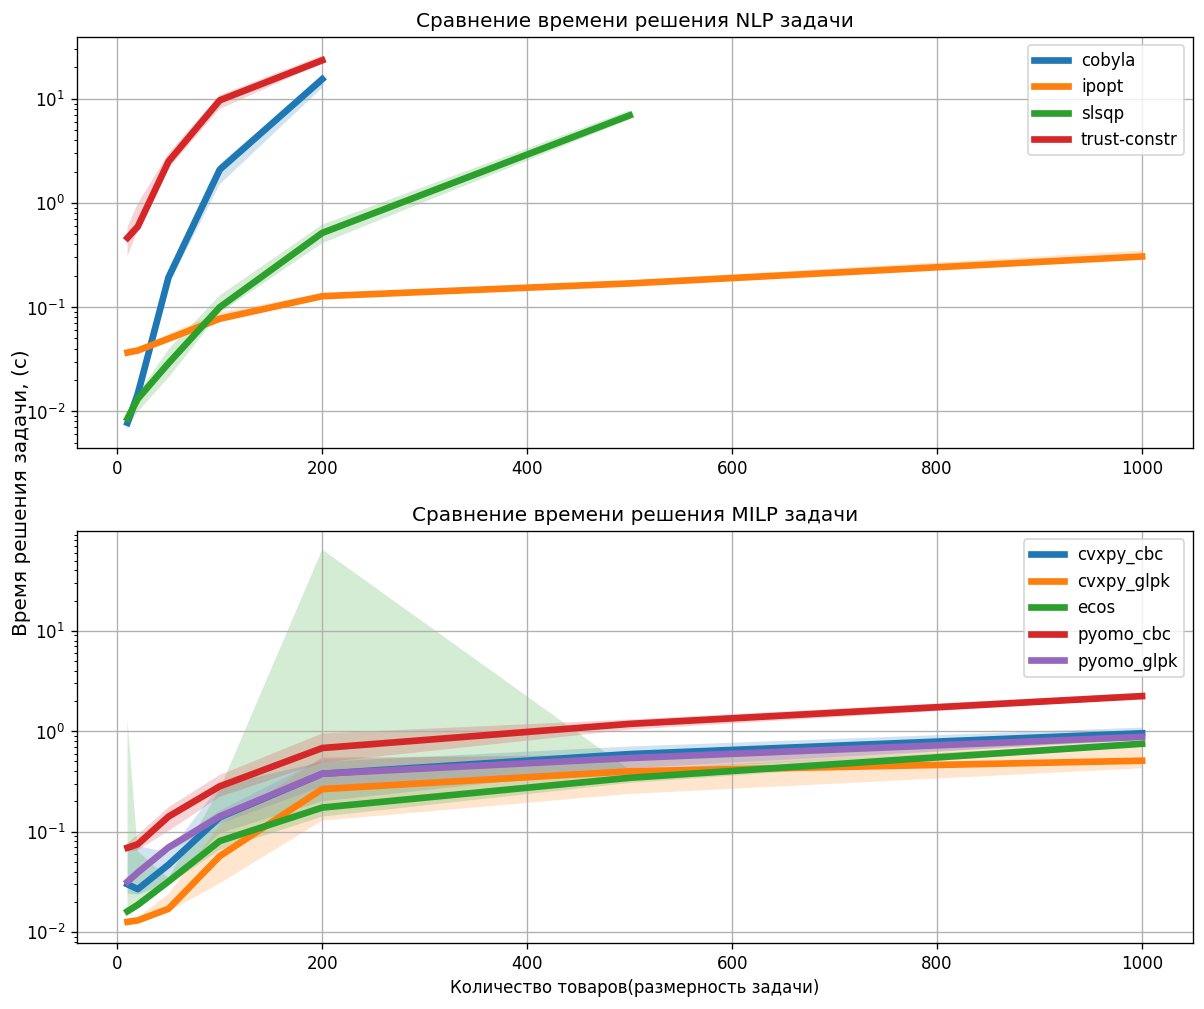

In [112]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False, dpi=120)
for (pr_type, solver), df in time_rep_df.groupby(['problem_type', 'solver']):
    ax_id = 0 if pr_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=4, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения MILP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.xlabel('Количество товаров(размерность задачи)')
plt.savefig('./images/time_solve_compare.png')
plt.show()


In [117]:
success_rate_df =\
    stats_df.groupby(['solver'])['success'].mean().reset_index().rename(columns={'success': 'success_rate'})

# dfi.export(success_rate_df, './images/success_rate.png')

[0728/230058.354337:INFO:headless_shell.cc(660)] Written to file /var/folders/bn/zpkz54h12h91dlsrft_4kvp40000gn/T/tmphju3vys9/temp.png.


### Пример запуска оптимизации

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)

In [14]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21

data = generate_data(100, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
#     'con_mrg': M_cur,
    'con_equal': True
}

opt_params['alpha'] = 0.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_min = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

opt_params['alpha'] = 1.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_max = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

N_grid = 30
M_grid = np.linspace(M_opt_min, M_opt_max, N_grid)
R_norm_res = np.zeros(N_grid)
M_norm_res = np.zeros(N_grid)
R_res = np.zeros(N_grid)
M_res = np.zeros(N_grid)


opt_params['alpha'] = 0.0
for i, M in enumerate(M_grid):
    opt_params['con_mrg'] = M
    res, t = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    R_norm_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt']) / R_cur
    M_norm_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt']) / M_cur

    R_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt'])
    M_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt'])
    

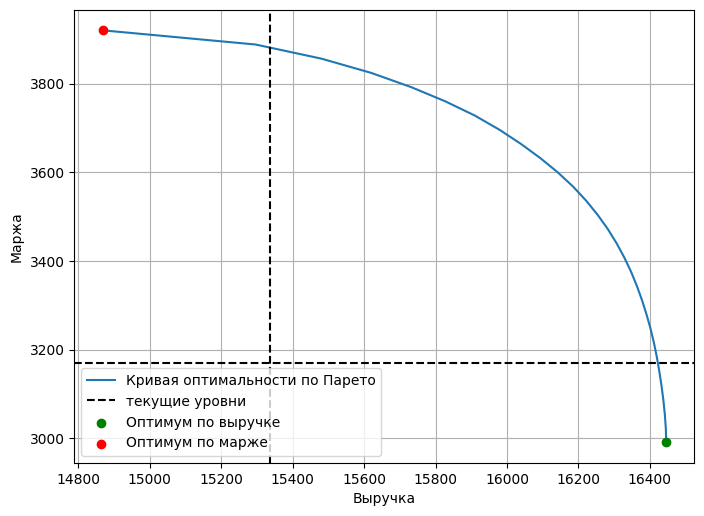

In [15]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_res, M_res, label='Кривая оптимальности по Парето')
plt.axvline(R_cur, ls='--', c='k', label='текущие уровни')
plt.axhline(M_cur, ls='--', c='k')
plt.scatter(R_res[0], M_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_res[-1], M_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

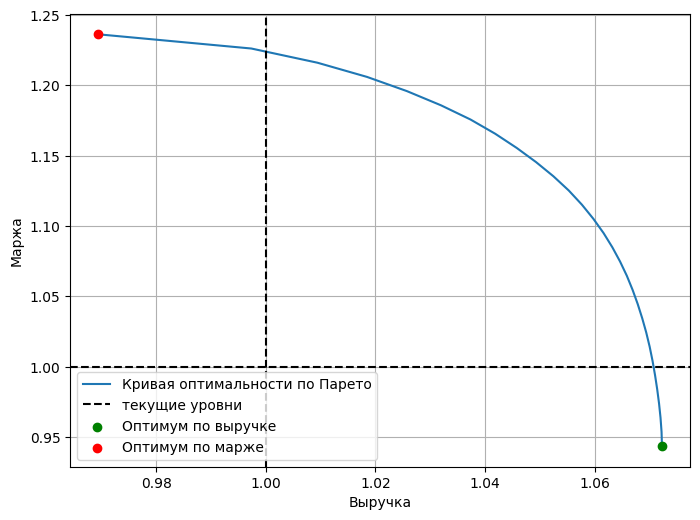

In [16]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_norm_res, M_norm_res, label='Кривая оптимальности по Парето')
plt.axvline(1, ls='--', c='k', label='текущие уровни')
plt.axhline(1, ls='--', c='k')
plt.scatter(R_norm_res[0], M_norm_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_norm_res[-1], M_norm_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

### Проверка на прочность  при решении ~100000 товаров

In [17]:
%%time
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21


data = generate_data(100, bounds_params, 21, 1)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur
}


CPU times: user 86.9 ms, sys: 960 µs, total: 87.8 ms
Wall time: 87.2 ms


In [18]:
%%time
try:
    res_pre_nlp, t_pre_nlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
    print(t_pre_nlp)
except Exception as e:
    print(e)

0.08372926712036133
CPU times: user 25.2 ms, sys: 14 ms, total: 39.1 ms
Wall time: 84 ms


In [19]:
res_pre_nlp

{'message': 'optimal',
 'status': 'ok',
 'model': <pyomo.core.base.PyomoModel.ConcreteModel at 0x1660d8230>,
 'data':     plu_line_idx       P         Q         E      PC       C  plu_idx  \
 0              0   91.99  1.291059 -1.049483   75.99   59.05        0   
 1              1  109.99  0.603437 -1.108792  119.99   82.03        1   
 2              2  121.99  1.622687 -1.681020  127.99   77.53        2   
 3              3   69.99  3.046905 -0.364532   76.99   54.38        3   
 4              4  105.99  0.511920 -1.949000  108.99   71.46        4   
 ..           ...     ...       ...       ...     ...     ...      ...   
 95            74  171.99  0.879510 -0.243858  165.99  120.08       95   
 96            75   82.99  1.778635 -1.450901   94.99   69.50       96   
 97            75   82.99  1.778635 -2.104893   94.99   69.50       97   
 98            76   68.99  2.057340 -1.520068   58.99   45.87       98   
 99            77  110.99  2.532499 -1.004277  110.99   70.78       9

In [20]:
%%time
try:
    res_1, t_1 = pricing_optimization(data, PyomoLpOptimizationModel, opt_params, 'glpk')
    print(t_1)
except Exception as e:
    print(e)

0.11621594429016113
CPU times: user 80.5 ms, sys: 21.7 ms, total: 102 ms
Wall time: 116 ms


In [21]:
res_1

{'message': 'optimal',
 'status': 'ok',
 'model': <pyomo.core.base.PyomoModel.ConcreteModel at 0x1660ae290>,
 'data':     plu_line_idx       P      PC       C  \
 0              0   91.99   75.99   59.05   
 1              1  109.99  119.99   82.03   
 2              2  121.99  127.99   77.53   
 3              3   69.99   76.99   54.38   
 4              4  105.99  108.99   71.46   
 ..           ...     ...     ...     ...   
 73            73  105.99  114.99  101.36   
 74            74  171.99  165.99  120.08   
 75            75   82.99   94.99   69.50   
 76            76   68.99   58.99   45.87   
 77            77  110.99  110.99   70.78   
 
                                                    Ps  \
 0   [82.99, 83.99, 84.99, 85.99, 86.99, 0.0, 0.0, ...   
 1   [101.99, 102.99, 104.99, 105.99, 106.99, 107.9...   
 2   [109.99, 110.99, 111.99, 112.99, 114.99, 115.9...   
 3   [64.99, 65.99, 66.99, 67.99, 68.99, 69.99, 70....   
 4   [94.99, 95.99, 97.99, 98.99, 99.99, 100.99, 10

In [22]:
df = res_1['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

20447.917248461024 18676.205931339475
3832.410431437097 3505.8795457206065


In [23]:
%%time
try:
    res_2, t_2 = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    print(t_2)
except Exception as e:
    print(e)

0.023185253143310547
CPU times: user 21.9 ms, sys: 2.27 ms, total: 24.2 ms
Wall time: 23.3 ms


In [24]:
df = res_2['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

20447.917248461024 18676.205931339475
3832.410431437097 3505.8795457206065


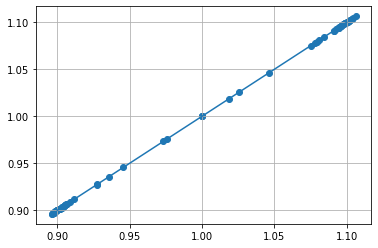

In [25]:
plt.scatter(res_1['data']['x_opt'], res_2['data']['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

In [31]:
res_1, t_1 = pricing_optimization(data, ScipyNlpOptimizationModel, opt_params, 'cobyla')
print(t_1)
res_1

0.02915501594543457


{'message': 'NaN result encountered.',
 'status': '5',
 'model':      fun: -109.10521472161506
    maxcv: 2.220446049250313e-16
  message: 'NaN result encountered.'
     nfev: 84
   status: 5
  success: False
        x: array([0.9       , 0.92727975, 0.9       , 1.1       , 0.9       ,
        1.1       , 1.1       , 1.1       , 0.9       , 1.1       ,
        0.9144037 , 0.9       , 0.9       , 1.1       , 0.9       ,
        0.9       , 1.1       , 0.9       , 1.07416749, 0.9       ,
        1.1       , 1.1       , 1.1       , 0.9       , 0.90930922,
        0.9       , 0.9       , 0.9       , 0.94043515, 0.9       ,
        0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
        0.9       , 0.92169538, 1.04792924, 0.97468329, 1.1       ,
        1.1       , 0.9       , 1.1       , 1.07332694, 0.9       ,
        0.9       , 1.1       , 1.1       , 1.1       , 0.9       ,
        0.9       , 0.9       , 1.1       , 1.1       , 1.1       ,
        0.9       , 0.90833905, 1

In [32]:
res_1['model']

     fun: -109.10521472161506
   maxcv: 2.220446049250313e-16
 message: 'NaN result encountered.'
    nfev: 84
  status: 5
 success: False
       x: array([0.9       , 0.92727975, 0.9       , 1.1       , 0.9       ,
       1.1       , 1.1       , 1.1       , 0.9       , 1.1       ,
       0.9144037 , 0.9       , 0.9       , 1.1       , 0.9       ,
       0.9       , 1.1       , 0.9       , 1.07416749, 0.9       ,
       1.1       , 1.1       , 1.1       , 0.9       , 0.90930922,
       0.9       , 0.9       , 0.9       , 0.94043515, 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.92169538, 1.04792924, 0.97468329, 1.1       ,
       1.1       , 0.9       , 1.1       , 1.07332694, 0.9       ,
       0.9       , 1.1       , 1.1       , 1.1       , 0.9       ,
       0.9       , 0.9       , 1.1       , 1.1       , 1.1       ,
       0.9       , 0.90833905, 1.09025586, 1.1       , 0.9       ,
       0.90397254, 1.1       , 1.1       , 1.07

In [28]:
res_2, t_2 = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
print(t_2)

0.0809941291809082


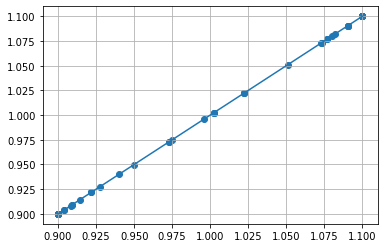

In [29]:
plt.scatter(res_1['data']['x_opt'], res_2['data']['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

In [280]:
df = res_1['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

21774.271142983842 20082.85912478442
4740.1973816583295 4641.317028230746


In [281]:
df = res_2['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

21774.2712708975 20082.85912478442
4740.22626941505 4641.317028230746


In [208]:
l = np.array([-1, 0])
u = np.array([0, 1])

np.random.uniform(l, u)

array([-0.42845791,  0.52580197])

In [34]:
from data_generator.data_generator import price_round

In [81]:
N_plu = 10
seed=0
"""
Генерация данных для тестирования оптимизационной модели
"""
np.random.seed(seed)

N_plu_line = 10
plu_line = list(range(N_plu_line))

plu_cnt_in_line = np.random.poisson(0.29, N_plu_line) + 1
# plu_cnt_in_line = plu_cnt_in_line[np.cumsum(plu_cnt_in_line) <= N_plu]
# plu_cnt_in_line[-1] = N_plu - plu_cnt_in_line.sum() + plu_cnt_in_line[-1]
N_plu = sum(plu_cnt_in_line)

data = pd.DataFrame({'plu_line_idx': plu_line})
data['plu_cnt'] = plu_cnt_in_line
data['P'] = price_round((np.random.gamma(2., 3., N_plu_line) + 4.) * 10.)
P_mean = data['P'].mean()
data['Q'] = np.random.chisquare(5., N_plu_line) * np.exp(-data['P'] / P_mean)
data['E'] = -np.random.gamma(1.7, 0.9, N_plu_line)
data['PC'] = price_round(
    data['P'] * np.random.normal(1.0, 0.2 * np.exp(-data['P'] / P_mean))
)
data['C'] = round(data['P'] / np.random.normal(1.28, 0.2, N_plu_line), 2)
data = data.loc[data.index.repeat(data['plu_cnt'])].reset_index(drop=True)
data['E_rc'] = abs(np.random.normal(1., 0.4, N_plu))
data['E'] = np.where(data['plu_cnt'] > 1.0, data['E'] * data['E_rc'], data['E'])
data.drop(columns=['plu_cnt', 'E_rc'], inplace=True)
data['plu_idx'] = list(range(N_plu))



In [82]:
data


,plu_line_idx,P,Q,E,PC,C,plu_idx
0,0,110.99,1.901200,-0.181287,109.99,97.10,0
1,1,115.99,1.386420,-1.587543,104.99,104.89,1
2,2,82.99,4.949323,-0.580855,85.99,71.28,2
3,3,166.99,0.480863,-2.824249,161.99,137.14,3
4,4,60.99,0.968538,-0.808371,60.99,47.23,4
5,5,105.99,2.095353,-1.734056,110.99,101.23,5
6,6,50.99,4.625211,-1.200804,51.99,34.92,6
7,7,70.99,1.843256,-0.958851,78.99,51.70,7
8,7,70.99,1.843256,-1.230886,78.99,51.70,8
9,7,70.99,1.843256,-1.011282,78.99,51.70,9


In [38]:
plu_cnt_in_line

array([1, 1, 1, 1, 1, 1, 1, 3])

In [37]:
plu_line

[0, 1, 2, 3, 4, 5, 6, 7]

x : Size=100, Index=x_index
    Key : Lower              : Value              : Upper              : Fixed : Stale : Domain
      0 :                0.9 : 0.9499781235743664 : 0.9499782585063594 : False : False :  Reals
      1 : 0.9272797527047912 : 0.9272797678731799 :                1.1 : False : False :  Reals
      2 :                0.9 :                0.9 :                1.1 : False : False :  Reals
      3 : 0.9350121445920845 :                1.1 :                1.1 : False : False :  Reals
      4 :                0.9 :                0.9 :                1.1 : False : False :  Reals
      5 :                0.9 :                1.1 :                1.1 : False : False :  Reals
      6 : 0.9969317199654277 :                1.1 :                1.1 : False : False :  Reals
      7 :                0.9 : 0.9401146696350888 :                1.1 : False : False :  Reals
      8 :                0.9 :                0.9 :                1.1 : False : False :  Reals
      9 : 0.

In [44]:
stats_df

,N,seed,solver,t,status,success,problem_type
0,1000,7,ipopt,0.293093,ok,True,nlp
1,1000,7,pyomo_cbc,2.626161,ok,True,lp
2,1000,7,pyomo_glpk,1.396869,ok,True,lp
3,1000,7,cvxpy_cbc,1.274290,ok,True,lp
4,1000,7,cvxpy_glpk,1.539935,ok,True,lp
...,...,...,...,...,...,...,...
1,1000,17,pyomo_cbc,2.448808,ok,True,lp
2,1000,17,pyomo_glpk,0.870086,ok,True,lp
3,1000,17,cvxpy_cbc,1.144621,ok,True,lp
4,1000,17,cvxpy_glpk,0.549957,ok,True,lp
